In [1]:
import math

from skimage import io
import numpy as np


In [2]:
def read_img(path, total_count, hori_count, img_size, img_gap):
    img = io.imread(path)
    print(img.shape)
    imgs = []
    labels = []

    count = 0
    while count < total_count:
        y, x = count % hori_count, count // hori_count
        x1 = (x + 1) * img_gap + x * img_size
        y1 = (y + 1) * img_gap + y * img_size
        x2 = x1 + img_size
        y2 = y1 + img_size

        imgs.append(img[x1:x2, y1:y2, 0:3] / 255.0)
        labels.append(str(count))

        count += 1
    return np.asarray(imgs, np.float32), np.asarray(labels, np.str_)


In [3]:
train_path = 'Gen_1.png'
train_image_count = 151
hori_count = 16
full_length = 64
img_gap = 1
channel = 3
train_data, train_label = read_img(train_path, train_image_count, hori_count, full_length, img_gap)


(651, 1041, 4)


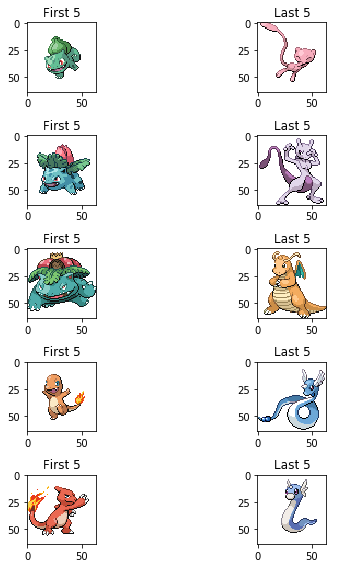

In [4]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.figure(figsize=(8, 8))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(train_data[i], vmin=0, vmax=1, cmap="gray")
    plt.title("First 5")
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(train_data[train_image_count - i - 1], vmin=0, vmax=1, cmap="gray")
    plt.title("Last 5")
plt.tight_layout()


In [5]:
def next_batch(dataset, start_point, batch_size):
    if start_point >= len(dataset):
        return []
    elif start_point + batch_size <= len(dataset):
        return dataset[start_point: start_point + batch_size]
    else:
        return dataset[start_point:]

In [6]:
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)
np.random.seed(0)
tf.set_random_seed(0)
batch_size = 50


In [7]:
d2_train_data = train_data.reshape((train_data.shape[0], train_data.shape[1] * train_data.shape[2] * train_data.shape[3]))
n_samples = len(d2_train_data)
n_samples


151

In [8]:
def xavier_init(fan_in, fan_out, constant=1):
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                             minval=low, maxval=high,
                             dtype=tf.float32)


In [9]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                 learning_rate=0.001, batch_size=5):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)

    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"],
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1,
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])

    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2,
                            n_hidden_gener_1, n_hidden_gener_2,
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights

    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']),
                                           biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                           biases['b2']))
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']),
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']),
                                           biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                           biases['b2']))
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']),
                                 biases['out_mean']))
        return x_reconstr_mean

    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-5 + self.x_reconstr_mean)
                           + (1 - self.x) * tf.log(1e-5 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)  # average over batch
        
        # Use ADAM optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})


In [10]:
def train(network_architecture, train_set, learning_rate=0.0001,
          batch_size=5, training_epochs=10, display_step=500):
    vae = VariationalAutoencoder(network_architecture,
                                 learning_rate=learning_rate,
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(math.ceil(n_samples / batch_size))
        # Loop over all batches
        for i in range(total_batch):
            batch_xs = next_batch(train_set, i * batch_size, batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if (epoch + 1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "cost=", "{:.9f}".format(avg_cost))
    return vae


In [11]:
network_architecture = \
    dict(n_hidden_recog_1=256,  # 1st layer encoder neurons
         n_hidden_recog_2=64,  # 2nd layer encoder neurons
         n_hidden_gener_1=64,  # 1st layer decoder neurons
         n_hidden_gener_2=256,  # 2nd layer decoder neurons
         n_input=full_length ** 2 * channel,  # input dimension
         n_z=32)  # dimensionality of latent space

vae = train(network_architecture, d2_train_data, learning_rate=0.0001, batch_size=batch_size, training_epochs=5000,
            display_step=500)


Epoch: 0500 cost= 4006.695293907


Epoch: 1000 cost= 3499.471520430


Epoch: 1500 cost= 3044.706958493


Epoch: 2000 cost= 2763.468296480


Epoch: 2500 cost= 2627.058784535


Epoch: 3000 cost= 2534.691837134


Epoch: 3500 cost= 2486.095342573


Epoch: 4000 cost= 2441.143697777


Epoch: 4500 cost= 2422.701925316


Epoch: 5000 cost= 2437.893252341


In [12]:
test_sample = next_batch(d2_train_data, 0, batch_size)
test_sample


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [13]:
x_reconstruct = vae.reconstruct(test_sample)
x_reconstruct[1].shape


(12288,)

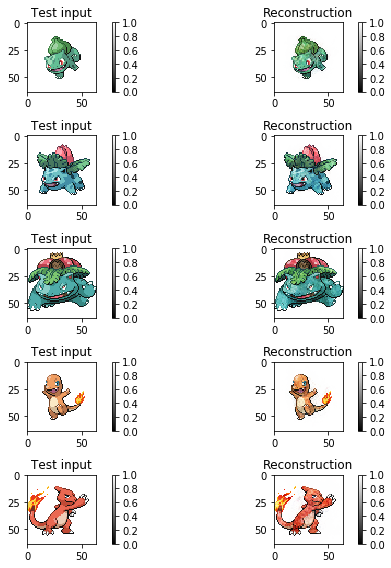

In [16]:
plt.figure(figsize=(8, 8))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(test_sample[i].reshape(full_length, full_length, channel), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(x_reconstruct[i].reshape(full_length, full_length, channel), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()


In [15]:
vae.sess.close()
